In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, uniform
import pandas as pd
np.random.seed(5)

# Importance Sampling Concept

Define the system. 
 * Spatial domain:  This represents the hydrologically homogeneous region
 * Damage function:  This represents the impact of an event happening in a given location.
 * Hazard function:  This is the probability that an event occurs at a given location.

In [33]:
domain = np.linspace(0, 1, 1000)  # Spatial domain
watershed = lambda x: norm(0.5, 0.05).pdf(x) * 10  # Damage function
hazard = uniform(0, 1)  # Hazard function

We are interested in characterizing the risk for this watershed.  Let's say we're interested in the mean of damage and the 90th percentile of damage.  We can solve for these values analytically or we may estimate their values numerically.  Below we estimate numerically.

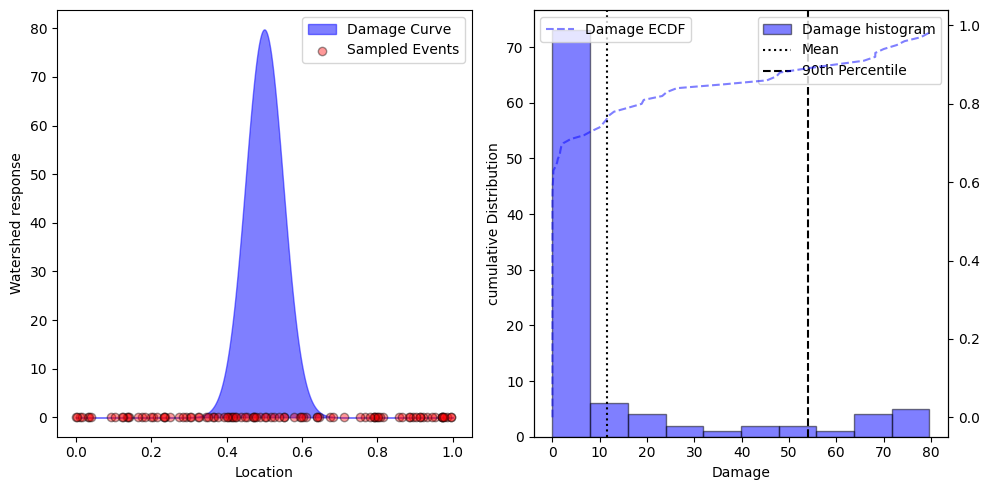

In [ ]:
x = hazard.rvs(100)
d = watershed(x)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].fill_between(domain, 0, watershed(domain), color='blue', alpha=0.5, label="Damage Curve")
axs[0].scatter(x, np.repeat(0, len(x)), fc="r", ec="k", lw=1, alpha=0.4, label="Sampled Events")
axs[0].set_xlabel("Location")
axs[0].set_ylabel("Watershed response")
axs[0].legend()
axs[1].hist(d, facecolor="b", edgecolor="k", alpha=0.5, label="Damage histogram")
axs[1].set_xlabel("Damage")
axs[1].set_ylabel("Frequency")
ax2 = axs[1].twinx()
ax2.plot(np.sort(d), np.arange(0, len(d)) / len(d), ls="dashed", c='b', alpha=0.5, label="Damage ECDF")
axs[1].set_ylabel("cumulative Distribution")
axs[1].axvline(np.mean(d), ls='dotted', c="k", label="Mean")
axs[1].axvline(np.quantile(d, 0.9), ls='dashed', c="k", label="90th Percentile")
axs[1].legend()
ax2.legend()
fig.tight_layout()

If we repeat this experiment many times we can measure the rate of convergence on the correct value with respect to sample size.

In [50]:
n = 1000
expected_values = []
ninetieth_percentiles = []
n_val = []
for i in range(5):
    for _ in range(1000):
        x = uniform(0, 1).rvs(n)
        f = watershed(x)
        expected_values.append(f.mean())
        ninetieth_percentiles.append(np.quantile(f, 0.90))
        n_val.append(n)
    n = int(n / 2)

summary = pd.DataFrame({"expected_value": expected_values, "ninetieth_percentile": ninetieth_percentiles, "sample_size": n_val})

<Axes: xlabel='sample_size', ylabel='expected_value'>

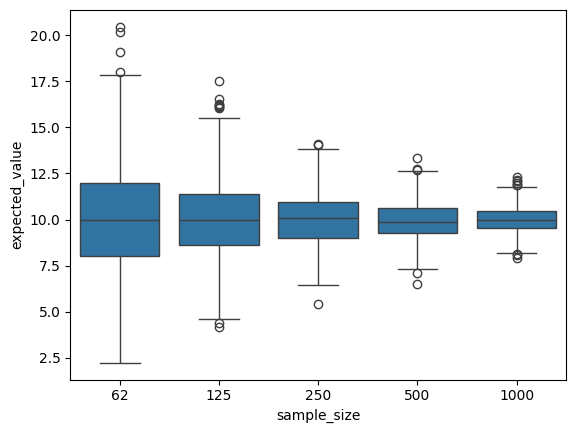

In [51]:
fig, ax = plt.subplots()
sns.boxplot(summary, x="sample_size", y="expected_value", ax=ax)

<Axes: xlabel='sample_size', ylabel='ninetieth_percentile'>

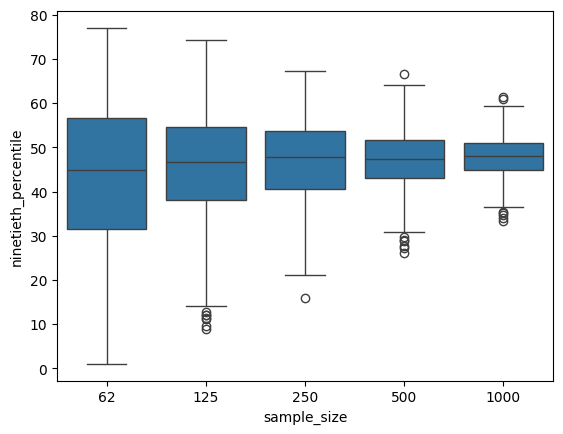

In [53]:
fig, ax = plt.subplots()
sns.boxplot(summary, x="sample_size", y="ninetieth_percentile", ax=ax)

Now we can repeat this approach with importance sampling.  We will define our sampling function as a normal distribution centered at 0.5 with 0.05 stdev.

In [67]:
q_x = norm(0.5, 0.05)
n = 1000
expected_values = []
ninetieth_percentiles = []
n_val = []
method = []
for i in range(5):
    for _ in range(1000):
        # Naive
        x = uniform(0, 1).rvs(n)
        f = watershed(x)
        expected_values.append(f.mean())
        ninetieth_percentiles.append(np.quantile(f, 0.90))
        n_val.append(n)
        method.append("naive")

        # Importance
        x = q_x.rvs(n)
        p_x_q_x = hazard.pdf(x) / q_x.pdf(x)
        f = watershed(x) * p_x_q_x
        expected_values.append(f.mean())
        ninetieth_percentiles.append(np.quantile(f, 0.90))
        n_val.append(n)
        method.append("importance")
    n = int(n / 2)

summary = pd.DataFrame({"expected_value": expected_values, "ninetieth_percentile": ninetieth_percentiles, "sample_size": n_val, "method": method})


<Axes: xlabel='sample_size', ylabel='expected_value'>

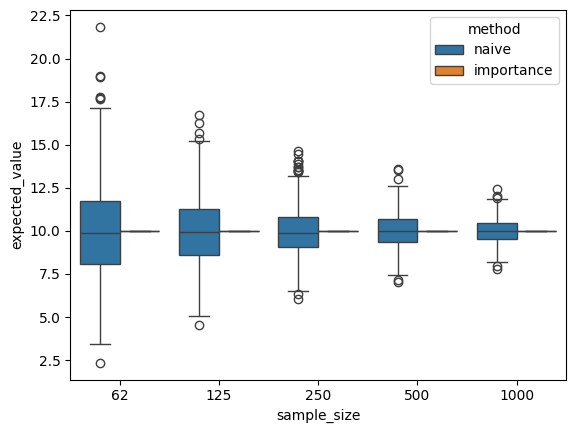

In [68]:
fig, ax = plt.subplots()
sns.boxplot(summary, x="sample_size", y="expected_value", ax=ax, hue="method")

Note that our mean estimation converges much faster than the naive sampling approach.

<Axes: xlabel='sample_size', ylabel='ninetieth_percentile'>

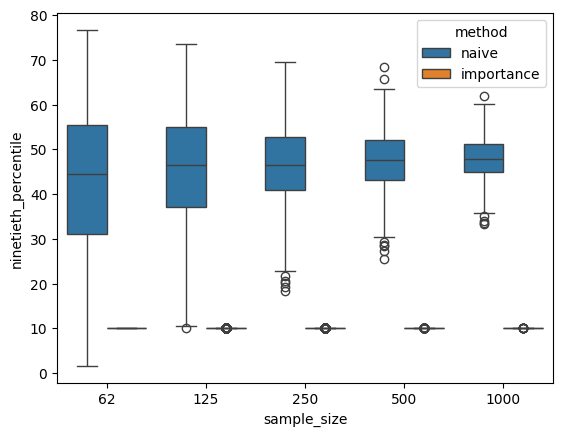

In [69]:
fig, ax = plt.subplots()
sns.boxplot(summary, x="sample_size", y="ninetieth_percentile", ax=ax, hue="method")

Note that the 90th percentile estimation is biased extremely low and does not converge to the true 90th percentile.